In [9]:
import torch
import os
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [10]:
# Define transformations (warm images)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random flip for data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Warm image
    transforms.RandomRotation(10),  # Small rotations to make the model robust
    transforms.Resize((224, 224)),  # Resize to fit the input of CNNs
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard ImageNet normalization
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/kaggle/input/brain-cancer/Brain_Cancer_Split/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/kaggle/input/brain-cancer/Brain_Cancer_Split/test', transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()

        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Define a fully connected layer
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjust according to the input size after pooling
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Pass through the convolutional layers with ReLU activations and pooling
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))

        # Flatten the output from conv layers
        x = x.view(-1, 128 * 28 * 28)

        # Pass through the fully connected layers
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)

        return x

In [13]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the model
model = CustomCNN(num_classes=3).to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

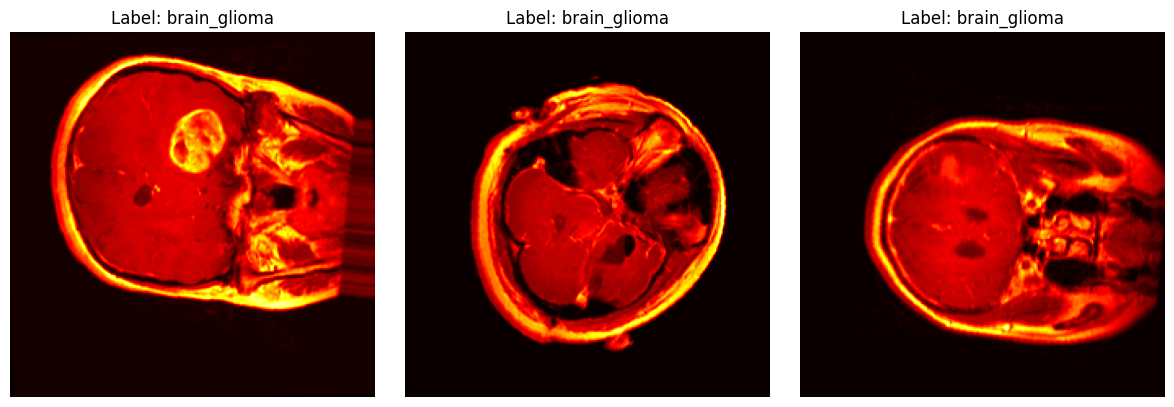

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define class names
class_names = ['brain_glioma', 'brain_menin', 'brain_tumor']

def imshow_three_from_dataset(dataset, class_names):
    """
    Directly takes 3 images from dataset and displays them in a warm tone.
    """
    # Get 3 sample images and labels
    samples = [dataset[i][0] for i in range(3)]
    labels = [dataset[i][1] for i in range(3)]
    titles = [f"Label: {class_names[label]}" for label in labels]

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    plt.figure(figsize=(12, 4))
    
    for i, img_tensor in enumerate(samples):
        img_tensor = img_tensor.cpu() * std + mean  # Unnormalize
        npimg = img_tensor.numpy().transpose((1, 2, 0))  # CHW to HWC
        grayscale = np.mean(npimg, axis=2)  # Convert to grayscale

        plt.subplot(1, 3, i + 1)
        plt.imshow(grayscale, cmap='hot')
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Now call the function
imshow_three_from_dataset(test_dataset, class_names)

In [15]:
num_epochs = 25
best_acc = 0.0
best_epoch = 0

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= total_val
    val_acc = 100 * correct_val / total_val

    # Store for graph
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Test Acc: {val_acc:.2f}%")

Epoch [1/25], Train Acc: 64.06%, Test Acc: 72.94%
Epoch [2/25], Train Acc: 75.23%, Test Acc: 77.81%
Epoch [3/25], Train Acc: 80.74%, Test Acc: 83.83%
Epoch [4/25], Train Acc: 84.91%, Test Acc: 86.30%
Epoch [5/25], Train Acc: 88.54%, Test Acc: 80.69%
Epoch [6/25], Train Acc: 89.39%, Test Acc: 88.37%
Epoch [7/25], Train Acc: 91.52%, Test Acc: 89.85%
Epoch [8/25], Train Acc: 93.93%, Test Acc: 86.30%
Epoch [9/25], Train Acc: 94.28%, Test Acc: 90.10%
Epoch [10/25], Train Acc: 95.71%, Test Acc: 91.09%
Epoch [11/25], Train Acc: 96.37%, Test Acc: 91.42%
Epoch [12/25], Train Acc: 96.26%, Test Acc: 90.26%
Epoch [13/25], Train Acc: 97.23%, Test Acc: 92.24%
Epoch [14/25], Train Acc: 98.04%, Test Acc: 89.03%
Epoch [15/25], Train Acc: 97.56%, Test Acc: 91.83%
Epoch [16/25], Train Acc: 97.73%, Test Acc: 92.99%
Epoch [17/25], Train Acc: 98.55%, Test Acc: 92.08%
Epoch [18/25], Train Acc: 98.18%, Test Acc: 91.83%
Epoch [19/25], Train Acc: 98.39%, Test Acc: 93.40%
Epoch [20/25], Train Acc: 98.64%, Test A

In [16]:
# Inside the training loop
if val_acc > best_acc:
    best_acc = val_acc
    best_epoch = epoch + 1
    torch.save(model.state_dict(), "best_brain_cancer_model.pth")
print(f"model saved as best_brain_cancer_model.pth with accuracy {best_acc:.2f}%")

model saved as best_brain_cancer_model.pth with accuracy 93.48%


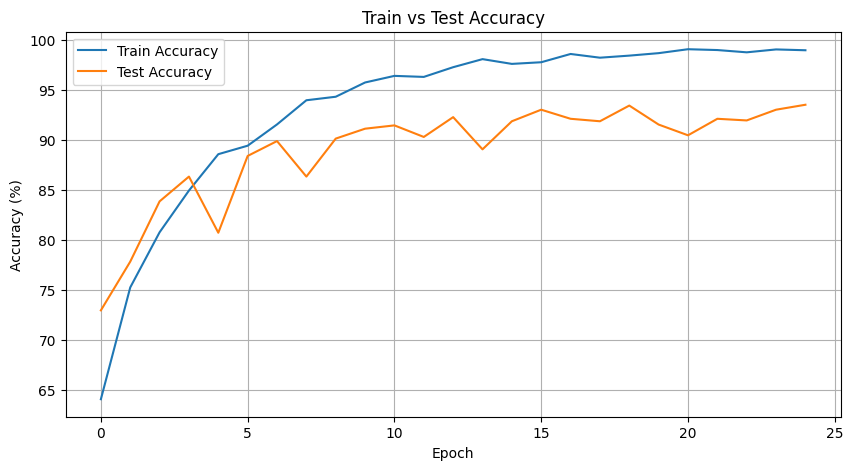

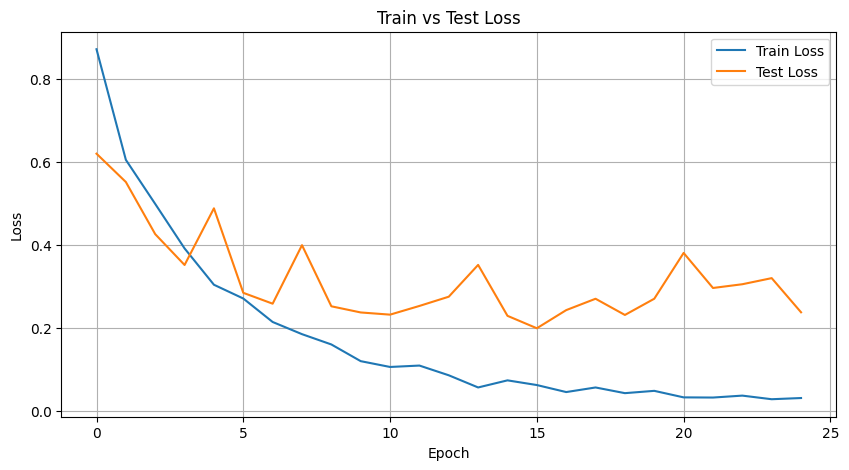

In [17]:
# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(10,5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.show()

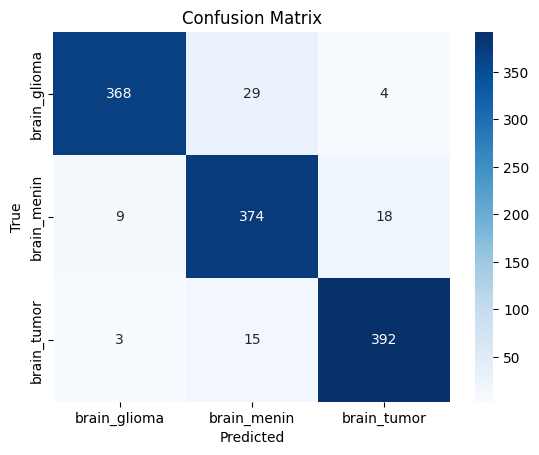

In [18]:
# Function to plot confusion matrix
def plot_confusion_matrix(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    
    with torch.no_grad():  # No gradient computation needed
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    cm_display = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Call confusion matrix function
plot_confusion_matrix(model, test_loader)

/tmp/ipykernel_31/3153606928.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path, map_location=device))


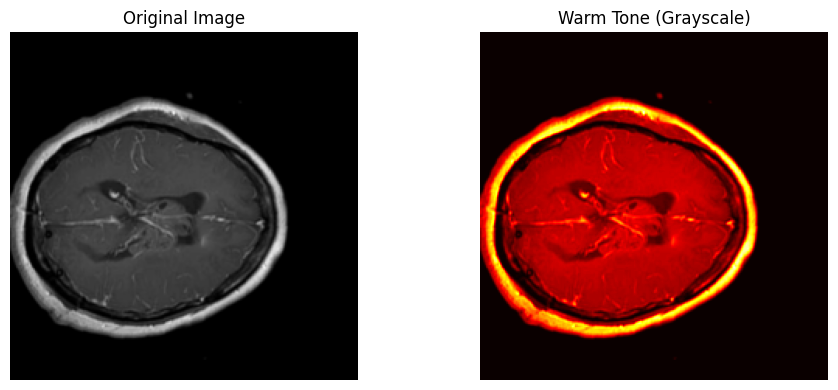

Predicted Label: brain_glioma


In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

# Load the best model
model_path = "best_brain_cancer_model.pth"
loaded_model = CustomCNN(num_classes=3)
loaded_model.load_state_dict(torch.load(model_path, map_location=device))
loaded_model = loaded_model.to(device)
loaded_model.eval()

# Define class names
class_names = ['brain_glioma', 'brain_menin', 'brain_tumor']

# Define transform
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Unnormalization function
def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Display function: original + warm tone
def show_original_and_warm(image_tensor):
    unnorm_img = unnormalize(image_tensor).cpu()
    npimg = unnorm_img.numpy().transpose((1, 2, 0))

    grayscale = np.mean(npimg, axis=2)

    plt.figure(figsize=(10, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(np.clip(npimg, 0, 1))
    plt.title("Original Image")
    plt.axis('off')

    # Warm grayscale image
    plt.subplot(1, 2, 2)
    plt.imshow(grayscale, cmap='hot')
    plt.title("Warm Tone (Grayscale)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Prediction function from image path
def predict_from_path(image_path):
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image)
    
    # Show original and warm images
    show_original_and_warm(img_tensor)

    # Prediction
    img_tensor = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = loaded_model(img_tensor)
        _, predicted = torch.max(output, 1)

    return class_names[predicted.item()]

# Example usage
image_path = "/kaggle/input/brain-cancer/Brain_Cancer_Split/test/brain_glioma/brain_glioma_0024.jpg"
predicted_label = predict_from_path(image_path)
print("Predicted Label:", predicted_label)